In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Choose Dataset

In [5]:
DATASET = 'mnist'
if DATASET     == 'mnist':
    epochs     = 100
    #lr         = 0.00004
    lr         = 0.03
    momentum   = 0.0    
    mean_imgs  = 0.1307
    std_imgs   = 0.3081
    imgs_shape = (1,28,28)

In [6]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
RES = os.path.join(ROOT,'results')

In [7]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary
from tqdm import tqdm

from mnist_archs import LeNet
from wtsgd import *

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [8]:
bs = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print(kwargs)

{'num_workers': 2, 'pin_memory': True}


In [9]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(ROOT +  '/data/' + DATASET, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                                           
                   ])),
    batch_size=bs, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    
    datasets.MNIST(ROOT + '/data/' + DATASET, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((mean_imgs,), (std_imgs,))                       
                   ])),
    batch_size=bs, shuffle=True, **kwargs)

In [10]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])


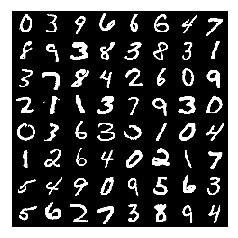

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

### Check labelling

Useful in case of random shuffling of labels

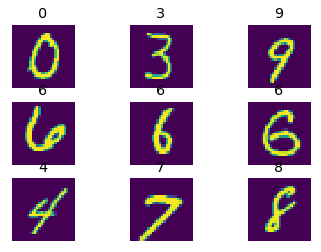

In [12]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i,0,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[i].item())

# Initialize network, optimizer and loss

In [13]:
model = LeNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = F.nll_loss

In [14]:
print(model)
print( summary(model, imgs_shape) )

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]            5020
            Linear-3                   [-1, 50]           16050
            Linear-4                   [-1, 10]             510
Total params: tensor(21840)
Trainable params: tensor(21840)
Non-trainable params: tensor(0)
----------------------------------------------------------------
None


In [15]:
train_loss   = []
train_acc    = []
valid_loss   = []
valid_acc    = []

In [16]:
for epoch in tqdm(range(epochs)):
    
    # init auxiliary grad and grad2
    auxgrad  = init_grad(model)
    auxgrad2 = init_grad(model)
    
        
    num_mb = 0
    for i, data in enumerate(train_loader, 0):
        
        num_mb += 1
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)  
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        # compute the grad
        loss.backward()
                
        # accumulate grad and grad2
        auxgrad  = acc_grad(auxgrad,model)
        auxgrad2 = acc_grad2(auxgrad2,model)
        
    
    # compute the snr 
    snr = compute_snr(auxgrad, auxgrad2, num_mb) 
    
    # temper the grad with the information on grad2
    with torch.no_grad():
        for param, s in zip(model.parameters(), snr): 
            param.grad[s < 1] = 0.0
            print((s < 1 ).sum())
       
    # this is now outside (modify learning rate accordingly ???)
    optimizer.step()
        
        
    # save model
    torch.save(model, os.path.join( RES, 'model_' + str(epoch) + '.pt') )
        
    # print statistics
    loss = 0.0
    total = 0    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            total += labels.size(0)
        l = loss/total
        valid_loss.append(l)
    
    loss = 0.0
    total = 0    
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels)
            total += labels.size(0)
        l = loss/total
        train_loss.append(l)        
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct/total
        valid_acc.append(acc)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = 100 * correct/total
        train_acc.append(acc)
        
    # print statistics
    print('Test loss : %g --- Test acc : %g %%' % ( valid_loss[-1], valid_acc[-1] )) 
   

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(7, device='cuda:0')
tensor(0, device='cuda:0')
tensor(153, device='cuda:0')
tensor(2, device='cuda:0')
tensor(856, device='cuda:0')
tensor(1, device='cuda:0')
tensor(28, device='cuda:0')
tensor(1, device='cuda:0')


  1%|          | 1/100 [00:07<12:31,  7.59s/it]

Test loss : 0.0366082 --- Test acc : 10.33 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(165, device='cuda:0')
tensor(0, device='cuda:0')
tensor(898, device='cuda:0')
tensor(1, device='cuda:0')
tensor(12, device='cuda:0')
tensor(0, device='cuda:0')


  2%|▏         | 2/100 [00:15<12:24,  7.60s/it]

Test loss : 0.0364911 --- Test acc : 10.37 %
tensor(11, device='cuda:0')
tensor(0, device='cuda:0')
tensor(169, device='cuda:0')
tensor(0, device='cuda:0')
tensor(852, device='cuda:0')
tensor(5, device='cuda:0')
tensor(17, device='cuda:0')
tensor(0, device='cuda:0')


  3%|▎         | 3/100 [00:22<12:17,  7.61s/it]

Test loss : 0.0364141 --- Test acc : 10.43 %
tensor(10, device='cuda:0')
tensor(0, device='cuda:0')
tensor(175, device='cuda:0')
tensor(0, device='cuda:0')
tensor(801, device='cuda:0')
tensor(3, device='cuda:0')
tensor(20, device='cuda:0')
tensor(1, device='cuda:0')


  4%|▍         | 4/100 [00:30<12:14,  7.65s/it]

Test loss : 0.0364542 --- Test acc : 10.28 %
tensor(11, device='cuda:0')
tensor(1, device='cuda:0')
tensor(144, device='cuda:0')
tensor(1, device='cuda:0')
tensor(845, device='cuda:0')
tensor(2, device='cuda:0')
tensor(22, device='cuda:0')
tensor(2, device='cuda:0')


  5%|▌         | 5/100 [00:38<12:03,  7.61s/it]

Test loss : 0.0363838 --- Test acc : 10.34 %
tensor(7, device='cuda:0')
tensor(0, device='cuda:0')
tensor(155, device='cuda:0')
tensor(1, device='cuda:0')
tensor(870, device='cuda:0')
tensor(3, device='cuda:0')
tensor(19, device='cuda:0')
tensor(1, device='cuda:0')


  6%|▌         | 6/100 [00:46<12:03,  7.70s/it]

Test loss : 0.0362489 --- Test acc : 10.46 %
tensor(12, device='cuda:0')
tensor(1, device='cuda:0')
tensor(150, device='cuda:0')
tensor(0, device='cuda:0')
tensor(789, device='cuda:0')
tensor(2, device='cuda:0')
tensor(22, device='cuda:0')
tensor(2, device='cuda:0')


  7%|▋         | 7/100 [00:53<11:55,  7.70s/it]

Test loss : 0.0360825 --- Test acc : 10.94 %
tensor(14, device='cuda:0')
tensor(0, device='cuda:0')
tensor(163, device='cuda:0')
tensor(0, device='cuda:0')
tensor(755, device='cuda:0')
tensor(1, device='cuda:0')
tensor(14, device='cuda:0')
tensor(2, device='cuda:0')


  8%|▊         | 8/100 [01:01<11:45,  7.67s/it]

Test loss : 0.0358814 --- Test acc : 17.48 %
tensor(12, device='cuda:0')
tensor(1, device='cuda:0')
tensor(159, device='cuda:0')
tensor(2, device='cuda:0')
tensor(986, device='cuda:0')
tensor(2, device='cuda:0')
tensor(20, device='cuda:0')
tensor(1, device='cuda:0')


  9%|▉         | 9/100 [01:09<11:38,  7.68s/it]

Test loss : 0.0358194 --- Test acc : 15.93 %
tensor(11, device='cuda:0')
tensor(2, device='cuda:0')
tensor(171, device='cuda:0')
tensor(3, device='cuda:0')
tensor(922, device='cuda:0')
tensor(4, device='cuda:0')
tensor(18, device='cuda:0')
tensor(1, device='cuda:0')


 10%|█         | 10/100 [01:16<11:29,  7.66s/it]

Test loss : 0.0357047 --- Test acc : 19.79 %
tensor(6, device='cuda:0')
tensor(1, device='cuda:0')
tensor(152, device='cuda:0')
tensor(2, device='cuda:0')
tensor(769, device='cuda:0')
tensor(1, device='cuda:0')
tensor(21, device='cuda:0')
tensor(1, device='cuda:0')


 11%|█         | 11/100 [01:24<11:22,  7.67s/it]

Test loss : 0.0356446 --- Test acc : 23.2 %
tensor(7, device='cuda:0')
tensor(0, device='cuda:0')
tensor(147, device='cuda:0')
tensor(2, device='cuda:0')
tensor(738, device='cuda:0')
tensor(2, device='cuda:0')
tensor(16, device='cuda:0')
tensor(1, device='cuda:0')


 12%|█▏        | 12/100 [01:31<11:14,  7.66s/it]

Test loss : 0.0355368 --- Test acc : 18.1 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(179, device='cuda:0')
tensor(0, device='cuda:0')
tensor(962, device='cuda:0')
tensor(3, device='cuda:0')
tensor(20, device='cuda:0')
tensor(0, device='cuda:0')


 13%|█▎        | 13/100 [01:39<11:07,  7.67s/it]

Test loss : 0.0354449 --- Test acc : 19.74 %
tensor(7, device='cuda:0')
tensor(0, device='cuda:0')
tensor(156, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1017, device='cuda:0')
tensor(3, device='cuda:0')
tensor(10, device='cuda:0')
tensor(0, device='cuda:0')


 14%|█▍        | 14/100 [01:47<10:59,  7.67s/it]

Test loss : 0.035372 --- Test acc : 18.97 %
tensor(7, device='cuda:0')
tensor(0, device='cuda:0')
tensor(148, device='cuda:0')
tensor(1, device='cuda:0')
tensor(955, device='cuda:0')
tensor(2, device='cuda:0')
tensor(16, device='cuda:0')
tensor(0, device='cuda:0')


 15%|█▌        | 15/100 [01:54<10:51,  7.66s/it]

Test loss : 0.0352819 --- Test acc : 18.73 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(161, device='cuda:0')
tensor(1, device='cuda:0')
tensor(993, device='cuda:0')
tensor(3, device='cuda:0')
tensor(16, device='cuda:0')
tensor(0, device='cuda:0')


 16%|█▌        | 16/100 [02:02<10:43,  7.67s/it]

Test loss : 0.0351568 --- Test acc : 25.24 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(173, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1050, device='cuda:0')
tensor(7, device='cuda:0')
tensor(23, device='cuda:0')
tensor(0, device='cuda:0')


 17%|█▋        | 17/100 [02:10<10:37,  7.68s/it]

Test loss : 0.0350862 --- Test acc : 26.38 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(167, device='cuda:0')
tensor(3, device='cuda:0')
tensor(861, device='cuda:0')
tensor(5, device='cuda:0')
tensor(24, device='cuda:0')
tensor(0, device='cuda:0')


 18%|█▊        | 18/100 [02:19<10:34,  7.73s/it]

Test loss : 0.0349776 --- Test acc : 26.38 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(164, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1122, device='cuda:0')
tensor(5, device='cuda:0')
tensor(24, device='cuda:0')
tensor(0, device='cuda:0')


 19%|█▉        | 19/100 [02:27<10:27,  7.74s/it]

Test loss : 0.0348517 --- Test acc : 30.29 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(156, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1018, device='cuda:0')
tensor(4, device='cuda:0')
tensor(18, device='cuda:0')
tensor(0, device='cuda:0')


 20%|██        | 20/100 [02:35<10:21,  7.77s/it]

Test loss : 0.0347162 --- Test acc : 30.95 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(132, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1069, device='cuda:0')
tensor(3, device='cuda:0')
tensor(24, device='cuda:0')
tensor(0, device='cuda:0')


 21%|██        | 21/100 [02:43<10:15,  7.79s/it]

Test loss : 0.0346404 --- Test acc : 25.67 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(177, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1053, device='cuda:0')
tensor(4, device='cuda:0')
tensor(18, device='cuda:0')
tensor(1, device='cuda:0')


 22%|██▏       | 22/100 [02:51<10:07,  7.78s/it]

Test loss : 0.0344904 --- Test acc : 30.77 %
tensor(10, device='cuda:0')
tensor(0, device='cuda:0')
tensor(163, device='cuda:0')
tensor(0, device='cuda:0')
tensor(851, device='cuda:0')
tensor(2, device='cuda:0')
tensor(24, device='cuda:0')
tensor(2, device='cuda:0')


 23%|██▎       | 23/100 [02:59<09:59,  7.79s/it]

Test loss : 0.0343204 --- Test acc : 34.84 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(149, device='cuda:0')
tensor(1, device='cuda:0')
tensor(951, device='cuda:0')
tensor(4, device='cuda:0')
tensor(15, device='cuda:0')
tensor(2, device='cuda:0')


 24%|██▍       | 24/100 [03:07<09:53,  7.81s/it]

Test loss : 0.0341987 --- Test acc : 33.36 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(167, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1021, device='cuda:0')
tensor(3, device='cuda:0')
tensor(23, device='cuda:0')
tensor(0, device='cuda:0')


 25%|██▌       | 25/100 [03:15<09:45,  7.81s/it]

Test loss : 0.0339996 --- Test acc : 36.81 %
tensor(7, device='cuda:0')
tensor(0, device='cuda:0')
tensor(165, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1006, device='cuda:0')
tensor(4, device='cuda:0')
tensor(24, device='cuda:0')
tensor(0, device='cuda:0')


 26%|██▌       | 26/100 [03:22<09:37,  7.80s/it]

Test loss : 0.0338925 --- Test acc : 34.67 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(159, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1074, device='cuda:0')
tensor(4, device='cuda:0')
tensor(29, device='cuda:0')
tensor(0, device='cuda:0')


 27%|██▋       | 27/100 [03:30<09:29,  7.81s/it]

Test loss : 0.033781 --- Test acc : 31.65 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(148, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1088, device='cuda:0')
tensor(4, device='cuda:0')
tensor(26, device='cuda:0')
tensor(0, device='cuda:0')


 28%|██▊       | 28/100 [03:38<09:22,  7.81s/it]

Test loss : 0.033659 --- Test acc : 43.02 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(158, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1002, device='cuda:0')
tensor(3, device='cuda:0')
tensor(20, device='cuda:0')
tensor(0, device='cuda:0')


 29%|██▉       | 29/100 [03:46<09:14,  7.81s/it]

Test loss : 0.0333802 --- Test acc : 41.44 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(154, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1059, device='cuda:0')
tensor(7, device='cuda:0')
tensor(28, device='cuda:0')
tensor(1, device='cuda:0')


 30%|███       | 30/100 [03:54<09:06,  7.80s/it]

Test loss : 0.0331895 --- Test acc : 35.12 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(148, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1048, device='cuda:0')
tensor(4, device='cuda:0')
tensor(26, device='cuda:0')
tensor(0, device='cuda:0')


 31%|███       | 31/100 [04:01<08:57,  7.79s/it]

Test loss : 0.0329455 --- Test acc : 34.56 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(148, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1133, device='cuda:0')
tensor(4, device='cuda:0')
tensor(24, device='cuda:0')
tensor(1, device='cuda:0')


 32%|███▏      | 32/100 [04:10<08:51,  7.81s/it]

Test loss : 0.0327141 --- Test acc : 38.01 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(136, device='cuda:0')
tensor(2, device='cuda:0')
tensor(1131, device='cuda:0')
tensor(3, device='cuda:0')
tensor(23, device='cuda:0')
tensor(0, device='cuda:0')


 33%|███▎      | 33/100 [04:17<08:43,  7.82s/it]

Test loss : 0.0324825 --- Test acc : 40.82 %
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(119, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1096, device='cuda:0')
tensor(4, device='cuda:0')
tensor(20, device='cuda:0')
tensor(0, device='cuda:0')


 34%|███▍      | 34/100 [04:26<08:36,  7.83s/it]

Test loss : 0.0321911 --- Test acc : 47.37 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(146, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1115, device='cuda:0')
tensor(3, device='cuda:0')
tensor(22, device='cuda:0')
tensor(1, device='cuda:0')


 35%|███▌      | 35/100 [04:34<08:29,  7.84s/it]

Test loss : 0.0319197 --- Test acc : 52.46 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(124, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1077, device='cuda:0')
tensor(4, device='cuda:0')
tensor(21, device='cuda:0')
tensor(0, device='cuda:0')


 36%|███▌      | 36/100 [04:42<08:21,  7.84s/it]

Test loss : 0.0317337 --- Test acc : 47.93 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(128, device='cuda:0')
tensor(2, device='cuda:0')
tensor(867, device='cuda:0')
tensor(3, device='cuda:0')
tensor(17, device='cuda:0')
tensor(0, device='cuda:0')


 37%|███▋      | 37/100 [04:50<08:13,  7.84s/it]

Test loss : 0.0313623 --- Test acc : 47.31 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(136, device='cuda:0')
tensor(1, device='cuda:0')
tensor(894, device='cuda:0')
tensor(4, device='cuda:0')
tensor(19, device='cuda:0')
tensor(0, device='cuda:0')


 38%|███▊      | 38/100 [04:58<08:06,  7.84s/it]

Test loss : 0.0310491 --- Test acc : 51.32 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(145, device='cuda:0')
tensor(1, device='cuda:0')
tensor(805, device='cuda:0')
tensor(2, device='cuda:0')
tensor(14, device='cuda:0')
tensor(1, device='cuda:0')


 39%|███▉      | 39/100 [05:06<07:59,  7.86s/it]

Test loss : 0.0305714 --- Test acc : 49.81 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(147, device='cuda:0')
tensor(1, device='cuda:0')
tensor(834, device='cuda:0')
tensor(3, device='cuda:0')
tensor(25, device='cuda:0')
tensor(2, device='cuda:0')


 40%|████      | 40/100 [05:14<07:51,  7.86s/it]

Test loss : 0.0301956 --- Test acc : 53.11 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(130, device='cuda:0')
tensor(1, device='cuda:0')
tensor(608, device='cuda:0')
tensor(0, device='cuda:0')
tensor(17, device='cuda:0')
tensor(0, device='cuda:0')


 41%|████      | 41/100 [05:22<07:44,  7.87s/it]

Test loss : 0.0298806 --- Test acc : 42.28 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(117, device='cuda:0')
tensor(0, device='cuda:0')
tensor(791, device='cuda:0')
tensor(1, device='cuda:0')
tensor(19, device='cuda:0')
tensor(1, device='cuda:0')


 42%|████▏     | 42/100 [05:30<07:36,  7.86s/it]

Test loss : 0.029366 --- Test acc : 49.83 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(121, device='cuda:0')
tensor(1, device='cuda:0')
tensor(551, device='cuda:0')
tensor(3, device='cuda:0')
tensor(12, device='cuda:0')
tensor(0, device='cuda:0')


 43%|████▎     | 43/100 [05:38<07:28,  7.87s/it]

Test loss : 0.0286134 --- Test acc : 56 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(124, device='cuda:0')
tensor(0, device='cuda:0')
tensor(534, device='cuda:0')
tensor(2, device='cuda:0')
tensor(15, device='cuda:0')
tensor(0, device='cuda:0')


 44%|████▍     | 44/100 [05:46<07:21,  7.88s/it]

Test loss : 0.0277628 --- Test acc : 55.29 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(125, device='cuda:0')
tensor(1, device='cuda:0')
tensor(591, device='cuda:0')
tensor(1, device='cuda:0')
tensor(19, device='cuda:0')
tensor(1, device='cuda:0')


 45%|████▌     | 45/100 [05:54<07:13,  7.89s/it]

Test loss : 0.0272732 --- Test acc : 61.72 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(133, device='cuda:0')
tensor(1, device='cuda:0')
tensor(542, device='cuda:0')
tensor(2, device='cuda:0')
tensor(16, device='cuda:0')
tensor(0, device='cuda:0')


 46%|████▌     | 46/100 [06:02<07:06,  7.89s/it]

Test loss : 0.0267261 --- Test acc : 53.09 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(111, device='cuda:0')
tensor(1, device='cuda:0')
tensor(506, device='cuda:0')
tensor(2, device='cuda:0')
tensor(19, device='cuda:0')
tensor(1, device='cuda:0')


 47%|████▋     | 47/100 [06:11<06:58,  7.90s/it]

Test loss : 0.0261407 --- Test acc : 55.98 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(95, device='cuda:0')
tensor(0, device='cuda:0')
tensor(499, device='cuda:0')
tensor(3, device='cuda:0')
tensor(24, device='cuda:0')
tensor(0, device='cuda:0')


 48%|████▊     | 48/100 [06:19<06:50,  7.90s/it]

Test loss : 0.0251757 --- Test acc : 63.39 %
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(99, device='cuda:0')
tensor(0, device='cuda:0')
tensor(576, device='cuda:0')
tensor(4, device='cuda:0')
tensor(11, device='cuda:0')
tensor(0, device='cuda:0')


 49%|████▉     | 49/100 [06:27<06:42,  7.90s/it]

Test loss : 0.0247393 --- Test acc : 57.15 %
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(115, device='cuda:0')
tensor(1, device='cuda:0')
tensor(600, device='cuda:0')
tensor(3, device='cuda:0')
tensor(21, device='cuda:0')
tensor(1, device='cuda:0')


 50%|█████     | 50/100 [06:35<06:35,  7.91s/it]

Test loss : 0.0241665 --- Test acc : 56.62 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(111, device='cuda:0')
tensor(1, device='cuda:0')
tensor(431, device='cuda:0')
tensor(2, device='cuda:0')
tensor(19, device='cuda:0')
tensor(0, device='cuda:0')


 51%|█████     | 51/100 [06:43<06:27,  7.90s/it]

Test loss : 0.0256036 --- Test acc : 41.88 %
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(54, device='cuda:0')
tensor(1, device='cuda:0')
tensor(511, device='cuda:0')
tensor(1, device='cuda:0')
tensor(19, device='cuda:0')
tensor(0, device='cuda:0')


 52%|█████▏    | 52/100 [06:51<06:19,  7.91s/it]

Test loss : 0.0248961 --- Test acc : 49.42 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(81, device='cuda:0')
tensor(1, device='cuda:0')
tensor(402, device='cuda:0')
tensor(0, device='cuda:0')
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')


 53%|█████▎    | 53/100 [06:59<06:11,  7.91s/it]

Test loss : 0.0218142 --- Test acc : 68.29 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(98, device='cuda:0')
tensor(0, device='cuda:0')
tensor(542, device='cuda:0')
tensor(2, device='cuda:0')
tensor(20, device='cuda:0')
tensor(0, device='cuda:0')


 54%|█████▍    | 54/100 [07:07<06:03,  7.91s/it]

Test loss : 0.0214698 --- Test acc : 59.26 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(100, device='cuda:0')
tensor(1, device='cuda:0')
tensor(456, device='cuda:0')
tensor(1, device='cuda:0')
tensor(11, device='cuda:0')
tensor(0, device='cuda:0')


 55%|█████▌    | 55/100 [07:15<05:55,  7.91s/it]

Test loss : 0.0213296 --- Test acc : 68.47 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(88, device='cuda:0')
tensor(0, device='cuda:0')
tensor(508, device='cuda:0')
tensor(2, device='cuda:0')
tensor(16, device='cuda:0')
tensor(0, device='cuda:0')


 56%|█████▌    | 56/100 [07:23<05:48,  7.91s/it]

Test loss : 0.0194506 --- Test acc : 69.18 %
tensor(2, device='cuda:0')
tensor(1, device='cuda:0')
tensor(158, device='cuda:0')
tensor(0, device='cuda:0')
tensor(603, device='cuda:0')
tensor(0, device='cuda:0')
tensor(22, device='cuda:0')
tensor(0, device='cuda:0')


 57%|█████▋    | 57/100 [07:30<05:40,  7.91s/it]

Test loss : 0.0203924 --- Test acc : 59.24 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(111, device='cuda:0')
tensor(0, device='cuda:0')
tensor(356, device='cuda:0')
tensor(1, device='cuda:0')
tensor(18, device='cuda:0')
tensor(0, device='cuda:0')


 58%|█████▊    | 58/100 [07:38<05:32,  7.91s/it]

Test loss : 0.0187052 --- Test acc : 70.32 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(108, device='cuda:0')
tensor(0, device='cuda:0')
tensor(543, device='cuda:0')
tensor(0, device='cuda:0')
tensor(12, device='cuda:0')
tensor(0, device='cuda:0')


 59%|█████▉    | 59/100 [07:46<05:24,  7.91s/it]

Test loss : 0.0209069 --- Test acc : 48.31 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(74, device='cuda:0')
tensor(0, device='cuda:0')
tensor(333, device='cuda:0')
tensor(0, device='cuda:0')
tensor(14, device='cuda:0')
tensor(0, device='cuda:0')


 60%|██████    | 60/100 [07:54<05:16,  7.91s/it]

Test loss : 0.0203528 --- Test acc : 55.62 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(78, device='cuda:0')
tensor(0, device='cuda:0')
tensor(491, device='cuda:0')
tensor(1, device='cuda:0')
tensor(15, device='cuda:0')
tensor(0, device='cuda:0')


 61%|██████    | 61/100 [08:03<05:08,  7.92s/it]

Test loss : 0.0181301 --- Test acc : 65.63 %
tensor(7, device='cuda:0')
tensor(0, device='cuda:0')
tensor(96, device='cuda:0')
tensor(1, device='cuda:0')
tensor(378, device='cuda:0')
tensor(2, device='cuda:0')
tensor(15, device='cuda:0')
tensor(0, device='cuda:0')


 62%|██████▏   | 62/100 [08:11<05:01,  7.92s/it]

Test loss : 0.0170349 --- Test acc : 68.77 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(118, device='cuda:0')
tensor(0, device='cuda:0')
tensor(405, device='cuda:0')
tensor(1, device='cuda:0')
tensor(10, device='cuda:0')
tensor(0, device='cuda:0')


 63%|██████▎   | 63/100 [08:18<04:52,  7.92s/it]

Test loss : 0.0177118 --- Test acc : 62.14 %
tensor(8, device='cuda:0')
tensor(0, device='cuda:0')
tensor(68, device='cuda:0')
tensor(0, device='cuda:0')
tensor(523, device='cuda:0')
tensor(1, device='cuda:0')
tensor(12, device='cuda:0')
tensor(0, device='cuda:0')


 64%|██████▍   | 64/100 [08:26<04:45,  7.92s/it]

Test loss : 0.0157866 --- Test acc : 77.38 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(117, device='cuda:0')
tensor(0, device='cuda:0')
tensor(512, device='cuda:0')
tensor(1, device='cuda:0')
tensor(16, device='cuda:0')
tensor(0, device='cuda:0')


 65%|██████▌   | 65/100 [08:35<04:37,  7.93s/it]

Test loss : 0.0161896 --- Test acc : 66.92 %
tensor(7, device='cuda:0')
tensor(1, device='cuda:0')
tensor(117, device='cuda:0')
tensor(0, device='cuda:0')
tensor(695, device='cuda:0')
tensor(2, device='cuda:0')
tensor(16, device='cuda:0')
tensor(1, device='cuda:0')


 66%|██████▌   | 66/100 [08:43<04:29,  7.93s/it]

Test loss : 0.0141134 --- Test acc : 77.35 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(129, device='cuda:0')
tensor(0, device='cuda:0')
tensor(639, device='cuda:0')
tensor(2, device='cuda:0')
tensor(17, device='cuda:0')
tensor(1, device='cuda:0')


 67%|██████▋   | 67/100 [08:51<04:21,  7.93s/it]

Test loss : 0.0161209 --- Test acc : 68.1 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(84, device='cuda:0')
tensor(0, device='cuda:0')
tensor(681, device='cuda:0')
tensor(1, device='cuda:0')
tensor(18, device='cuda:0')
tensor(0, device='cuda:0')


 68%|██████▊   | 68/100 [08:59<04:13,  7.93s/it]

Test loss : 0.0236194 --- Test acc : 51.48 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(35, device='cuda:0')
tensor(0, device='cuda:0')
tensor(453, device='cuda:0')
tensor(0, device='cuda:0')
tensor(13, device='cuda:0')
tensor(0, device='cuda:0')


 69%|██████▉   | 69/100 [09:07<04:05,  7.93s/it]

Test loss : 0.0178276 --- Test acc : 60.11 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(93, device='cuda:0')
tensor(0, device='cuda:0')
tensor(391, device='cuda:0')
tensor(1, device='cuda:0')
tensor(12, device='cuda:0')
tensor(0, device='cuda:0')


 70%|███████   | 70/100 [09:15<03:58,  7.94s/it]

Test loss : 0.018148 --- Test acc : 59 %
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(74, device='cuda:0')
tensor(0, device='cuda:0')
tensor(345, device='cuda:0')
tensor(1, device='cuda:0')
tensor(12, device='cuda:0')
tensor(1, device='cuda:0')


 71%|███████   | 71/100 [09:23<03:50,  7.94s/it]

Test loss : 0.0150989 --- Test acc : 70.98 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(110, device='cuda:0')
tensor(0, device='cuda:0')
tensor(552, device='cuda:0')
tensor(2, device='cuda:0')
tensor(12, device='cuda:0')
tensor(1, device='cuda:0')


 72%|███████▏  | 72/100 [09:31<03:42,  7.94s/it]

Test loss : 0.0148155 --- Test acc : 74.48 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(111, device='cuda:0')
tensor(1, device='cuda:0')
tensor(421, device='cuda:0')
tensor(1, device='cuda:0')
tensor(10, device='cuda:0')
tensor(0, device='cuda:0')


 73%|███████▎  | 73/100 [09:39<03:34,  7.93s/it]

Test loss : 0.0128945 --- Test acc : 78.81 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(143, device='cuda:0')
tensor(0, device='cuda:0')
tensor(479, device='cuda:0')
tensor(1, device='cuda:0')
tensor(19, device='cuda:0')
tensor(0, device='cuda:0')


 74%|███████▍  | 74/100 [09:47<03:26,  7.93s/it]

Test loss : 0.013281 --- Test acc : 76.56 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(114, device='cuda:0')
tensor(0, device='cuda:0')
tensor(563, device='cuda:0')
tensor(1, device='cuda:0')
tensor(14, device='cuda:0')
tensor(0, device='cuda:0')


 75%|███████▌  | 75/100 [09:55<03:18,  7.94s/it]

Test loss : 0.0146603 --- Test acc : 69.92 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(91, device='cuda:0')
tensor(1, device='cuda:0')
tensor(408, device='cuda:0')
tensor(1, device='cuda:0')
tensor(16, device='cuda:0')
tensor(1, device='cuda:0')


 76%|███████▌  | 76/100 [10:03<03:10,  7.94s/it]

Test loss : 0.0125729 --- Test acc : 76.93 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(87, device='cuda:0')
tensor(0, device='cuda:0')
tensor(574, device='cuda:0')
tensor(1, device='cuda:0')
tensor(20, device='cuda:0')
tensor(0, device='cuda:0')


 77%|███████▋  | 77/100 [10:10<03:02,  7.93s/it]

Test loss : 0.0125628 --- Test acc : 75.16 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(98, device='cuda:0')
tensor(0, device='cuda:0')
tensor(723, device='cuda:0')
tensor(1, device='cuda:0')
tensor(15, device='cuda:0')
tensor(0, device='cuda:0')


 78%|███████▊  | 78/100 [10:19<02:54,  7.94s/it]

Test loss : 0.0106852 --- Test acc : 81.07 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(184, device='cuda:0')
tensor(0, device='cuda:0')
tensor(744, device='cuda:0')
tensor(3, device='cuda:0')
tensor(26, device='cuda:0')
tensor(0, device='cuda:0')


 79%|███████▉  | 79/100 [10:27<02:46,  7.94s/it]

Test loss : 0.0117815 --- Test acc : 75.92 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(147, device='cuda:0')
tensor(1, device='cuda:0')
tensor(635, device='cuda:0')
tensor(0, device='cuda:0')
tensor(25, device='cuda:0')
tensor(0, device='cuda:0')


 80%|████████  | 80/100 [10:34<02:38,  7.93s/it]

Test loss : 0.0117337 --- Test acc : 77.91 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(112, device='cuda:0')
tensor(1, device='cuda:0')
tensor(451, device='cuda:0')
tensor(1, device='cuda:0')
tensor(21, device='cuda:0')
tensor(0, device='cuda:0')


 81%|████████  | 81/100 [10:42<02:30,  7.94s/it]

Test loss : 0.0103212 --- Test acc : 82.77 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(157, device='cuda:0')
tensor(0, device='cuda:0')
tensor(703, device='cuda:0')
tensor(2, device='cuda:0')
tensor(30, device='cuda:0')
tensor(1, device='cuda:0')


 82%|████████▏ | 82/100 [10:51<02:22,  7.94s/it]

Test loss : 0.0120266 --- Test acc : 79.19 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(80, device='cuda:0')
tensor(1, device='cuda:0')
tensor(509, device='cuda:0')
tensor(2, device='cuda:0')
tensor(17, device='cuda:0')
tensor(0, device='cuda:0')


 83%|████████▎ | 83/100 [10:58<02:14,  7.94s/it]

Test loss : 0.0119499 --- Test acc : 75.58 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(89, device='cuda:0')
tensor(0, device='cuda:0')
tensor(698, device='cuda:0')
tensor(2, device='cuda:0')
tensor(21, device='cuda:0')
tensor(0, device='cuda:0')


 84%|████████▍ | 84/100 [11:07<02:07,  7.94s/it]

Test loss : 0.0143491 --- Test acc : 67.4 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(76, device='cuda:0')
tensor(1, device='cuda:0')
tensor(666, device='cuda:0')
tensor(2, device='cuda:0')
tensor(20, device='cuda:0')
tensor(0, device='cuda:0')


 85%|████████▌ | 85/100 [11:15<01:59,  7.94s/it]

Test loss : 0.0132848 --- Test acc : 70.24 %
tensor(8, device='cuda:0')
tensor(1, device='cuda:0')
tensor(84, device='cuda:0')
tensor(0, device='cuda:0')
tensor(596, device='cuda:0')
tensor(1, device='cuda:0')
tensor(14, device='cuda:0')
tensor(0, device='cuda:0')


 86%|████████▌ | 86/100 [11:23<01:51,  7.95s/it]

Test loss : 0.0121374 --- Test acc : 72.59 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(89, device='cuda:0')
tensor(0, device='cuda:0')
tensor(550, device='cuda:0')
tensor(2, device='cuda:0')
tensor(22, device='cuda:0')
tensor(0, device='cuda:0')


 87%|████████▋ | 87/100 [11:31<01:43,  7.95s/it]

Test loss : 0.0134244 --- Test acc : 72.03 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(56, device='cuda:0')
tensor(0, device='cuda:0')
tensor(571, device='cuda:0')
tensor(2, device='cuda:0')
tensor(28, device='cuda:0')
tensor(1, device='cuda:0')


 88%|████████▊ | 88/100 [11:39<01:35,  7.95s/it]

Test loss : 0.01011 --- Test acc : 78.59 %
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(97, device='cuda:0')
tensor(0, device='cuda:0')
tensor(809, device='cuda:0')
tensor(3, device='cuda:0')
tensor(24, device='cuda:0')
tensor(0, device='cuda:0')


 89%|████████▉ | 89/100 [11:47<01:27,  7.95s/it]

Test loss : 0.00963775 --- Test acc : 82.66 %
tensor(5, device='cuda:0')
tensor(0, device='cuda:0')
tensor(155, device='cuda:0')
tensor(0, device='cuda:0')
tensor(773, device='cuda:0')
tensor(1, device='cuda:0')
tensor(29, device='cuda:0')
tensor(0, device='cuda:0')


 90%|█████████ | 90/100 [11:55<01:19,  7.95s/it]

Test loss : 0.0110275 --- Test acc : 77.37 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(86, device='cuda:0')
tensor(0, device='cuda:0')
tensor(419, device='cuda:0')
tensor(0, device='cuda:0')
tensor(22, device='cuda:0')
tensor(0, device='cuda:0')


 91%|█████████ | 91/100 [12:03<01:11,  7.95s/it]

Test loss : 0.0120083 --- Test acc : 73.93 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(105, device='cuda:0')
tensor(0, device='cuda:0')
tensor(490, device='cuda:0')
tensor(0, device='cuda:0')
tensor(18, device='cuda:0')
tensor(0, device='cuda:0')


 92%|█████████▏| 92/100 [12:11<01:03,  7.95s/it]

Test loss : 0.0115837 --- Test acc : 76.52 %
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
tensor(110, device='cuda:0')
tensor(1, device='cuda:0')
tensor(820, device='cuda:0')
tensor(4, device='cuda:0')
tensor(16, device='cuda:0')
tensor(0, device='cuda:0')


 93%|█████████▎| 93/100 [12:19<00:55,  7.95s/it]

Test loss : 0.0108923 --- Test acc : 75.48 %
tensor(9, device='cuda:0')
tensor(0, device='cuda:0')
tensor(105, device='cuda:0')
tensor(0, device='cuda:0')
tensor(554, device='cuda:0')
tensor(1, device='cuda:0')
tensor(14, device='cuda:0')
tensor(0, device='cuda:0')


 94%|█████████▍| 94/100 [12:27<00:47,  7.95s/it]

Test loss : 0.00891394 --- Test acc : 83.79 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(216, device='cuda:0')
tensor(0, device='cuda:0')
tensor(887, device='cuda:0')
tensor(4, device='cuda:0')
tensor(25, device='cuda:0')
tensor(0, device='cuda:0')


 95%|█████████▌| 95/100 [12:35<00:39,  7.96s/it]

Test loss : 0.00895576 --- Test acc : 85.22 %
tensor(4, device='cuda:0')
tensor(0, device='cuda:0')
tensor(158, device='cuda:0')
tensor(0, device='cuda:0')
tensor(636, device='cuda:0')
tensor(1, device='cuda:0')
tensor(24, device='cuda:0')
tensor(0, device='cuda:0')


 96%|█████████▌| 96/100 [12:43<00:31,  7.95s/it]

Test loss : 0.00948619 --- Test acc : 80.59 %
tensor(3, device='cuda:0')
tensor(0, device='cuda:0')
tensor(96, device='cuda:0')
tensor(0, device='cuda:0')
tensor(655, device='cuda:0')
tensor(3, device='cuda:0')
tensor(23, device='cuda:0')
tensor(0, device='cuda:0')


 97%|█████████▋| 97/100 [12:51<00:23,  7.96s/it]

Test loss : 0.0105274 --- Test acc : 77.83 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(106, device='cuda:0')
tensor(1, device='cuda:0')
tensor(679, device='cuda:0')
tensor(2, device='cuda:0')
tensor(22, device='cuda:0')
tensor(0, device='cuda:0')


 98%|█████████▊| 98/100 [13:00<00:15,  7.96s/it]

Test loss : 0.0085044 --- Test acc : 85.11 %
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(143, device='cuda:0')
tensor(0, device='cuda:0')
tensor(740, device='cuda:0')
tensor(0, device='cuda:0')
tensor(20, device='cuda:0')
tensor(0, device='cuda:0')


 99%|█████████▉| 99/100 [13:08<00:07,  7.96s/it]

Test loss : 0.0088198 --- Test acc : 83.56 %
tensor(6, device='cuda:0')
tensor(0, device='cuda:0')
tensor(158, device='cuda:0')
tensor(0, device='cuda:0')
tensor(709, device='cuda:0')
tensor(1, device='cuda:0')
tensor(21, device='cuda:0')
tensor(0, device='cuda:0')


100%|██████████| 100/100 [13:16<00:00,  7.96s/it]

Test loss : 0.0118166 --- Test acc : 73.11 %


In [17]:
# save loss and accuracies in a dictionary
tags = ['train_loss','valid_loss', 'train_acc', 'valid_acc' ]
vals = [train_loss, valid_loss, train_acc, valid_acc]
training_data = dict(zip(tags, vals))
file = open( os.path.join( RES, "training_data" ) , 'wb' ) 
pickle.dump(training_data,file)
print('Finished training.')

Finished training.


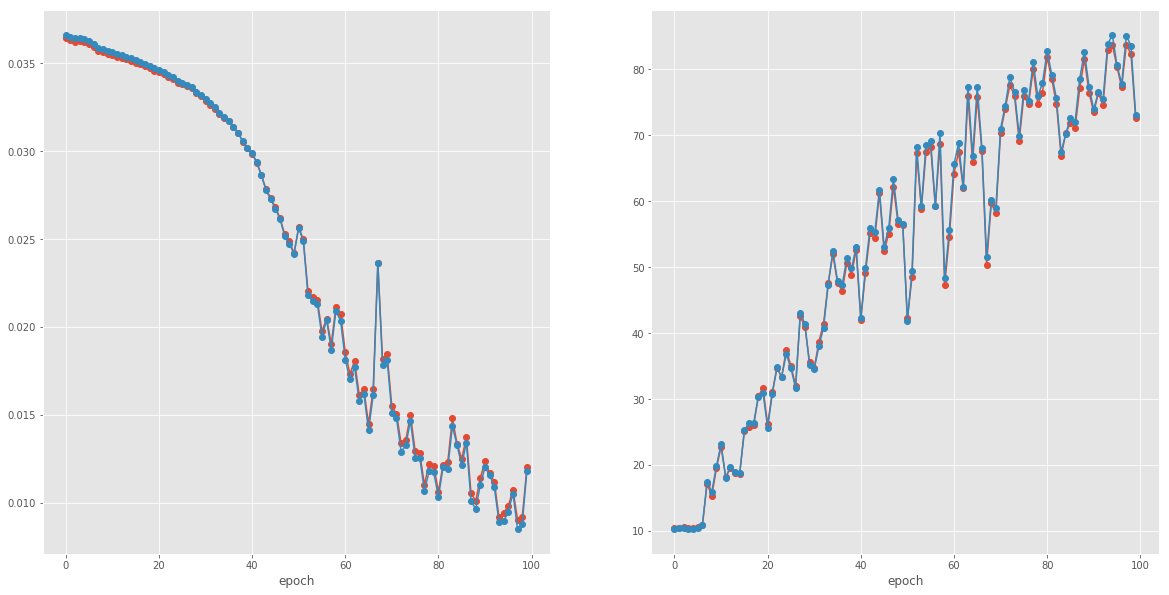

In [24]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(train_loss,'-o',label='training loss')
plt.plot(valid_loss,'-o',label='test loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(train_acc,'-o',label='training accuracy')
plt.plot(valid_acc,'-o',label='test accuracy')
plt.xlabel('epoch')
plt.show()